# T5 English to Portuguese translate
## Name: Rafael Gonçalves

## Configuration

In [0]:
# General configuration
model_name = "t5-small"
use_cuda = True

In [0]:
# Install packages
! pip install --quiet sacrebleu
! pip install --quiet pytorch-lightning==0.7.5
! pip install --quiet transformers

In [3]:
# Imports
import gzip
import nvidia_smi
import os, functools
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import random
import sacrebleu
from multiprocessing import cpu_count
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from google.colab import drive

from pytorch_lightning.callbacks import ModelCheckpoint

from transformers import T5ForConditionalGeneration
from transformers import T5Tokenizer
from transformers import get_constant_schedule_with_warmup, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from typing import Dict
from typing import List
from typing import Tuple

INFO:transformers.file_utils:PyTorch version 1.5.0+cu101 available.
INFO:transformers.file_utils:TensorFlow version 2.2.0-rc4 available.


In [0]:
# Ranger (RAdam + LookAhead) from: https://github.com/cedrickchee/ranger-optimizer
import math
import torch
from torch.optim.optimizer import Optimizer, required
import itertools as it


class Ranger(Optimizer):
    def __init__(
        self,
        params,
        lr=1e-3,
        alpha=0.5,
        k=6,
        betas=(0.9, 0.999),
        eps=1e-8,
        weight_decay=0,
    ):
        # parameter checks
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f"Invalid slow update rate: {alpha}")
        if not 1 <= k:
            raise ValueError(f"Invalid lookahead steps: {k}")
        if not lr > 0:
            raise ValueError(f"Invalid Learning Rate: {lr}")
        if not eps > 0:
            raise ValueError(f"Invalid eps: {eps}")

        # prep defaults and init torch.optim base
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super().__init__(params, defaults)

        # now we can get to work...
        for group in self.param_groups:
            group["step_counter"] = 0
            # print("group step counter init")

        # look ahead params
        self.alpha = alpha
        self.k = k

        # radam buffer for state
        self.radam_buffer = [[None, None, None] for ind in range(10)]

        # lookahead weights
        self.slow_weights = [
            [p.clone().detach() for p in group["params"]] for group in self.param_groups
        ]

        # don't use grad for lookahead weights
        for w in it.chain(*self.slow_weights):
            w.requires_grad = False

    def __setstate__(self, state):
        print("set state called")
        super(Ranger, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        # note - below is commented out b/c I have other work that passes back the loss as a float, and thus not a callable closure.
        # Uncomment if you need to use the actual closure...

        # if closure is not None:
        # loss = closure()

        # ------------ radam
        for group in self.param_groups:

            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError("RAdam does not support sparse gradients")

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state["step"] = 0
                    state["exp_avg"] = torch.zeros_like(p_data_fp32)
                    state["exp_avg_sq"] = torch.zeros_like(p_data_fp32)
                else:
                    state["exp_avg"] = state["exp_avg"].type_as(p_data_fp32)
                    state["exp_avg_sq"] = state["exp_avg_sq"].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"]
                beta1, beta2 = group["betas"]

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state["step"] += 1
                buffered = self.radam_buffer[int(state["step"] % 10)]
                if state["step"] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state["step"]
                    beta2_t = beta2 ** state["step"]
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state["step"] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma
                    if N_sma > 5:
                        step_size = group["lr"] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state["step"])
                    else:
                        step_size = group["lr"] / (1 - beta1 ** state["step"])
                    buffered[2] = step_size

                if group["weight_decay"] != 0:
                    p_data_fp32.add_(-group["weight_decay"] * group["lr"], p_data_fp32)

                if N_sma > 5:
                    denom = exp_avg_sq.sqrt().add_(group["eps"])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        # ---------------- end radam step

        # look ahead tracking and updating if latest batch = k
        for group, slow_weights in zip(self.param_groups, self.slow_weights):
            group["step_counter"] += 1
            if group["step_counter"] % self.k != 0:
                continue
            for p, q in zip(group["params"], slow_weights):
                if p.grad is None:
                    continue
                q.data.add_(self.alpha, p.data - q.data)
                p.data.copy_(q.data)

        return loss

In [0]:
def gpu_mem_restore(func):
    "Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"
    
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None

    return wrapper

In [0]:
# Important: Fix seeds so we can replicate results
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.random.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [7]:
print(f"Pytorch Lightning Version: {pl.__version__}")
if use_cuda:
    nvidia_smi.nvmlInit()
    handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
    print(f"Device name: {nvidia_smi.nvmlDeviceGetName(handle)}")

nproc = cpu_count()
print('CPU cores:', nproc)
def gpu_usage():
    global handle
    return str(nvidia_smi.nvmlDeviceGetUtilizationRates(handle).gpu) + '%'

Pytorch Lightning Version: 0.7.5
Device name: b'Tesla P100-PCIE-16GB'
CPU cores: 4


In [0]:
plt.rcParams['figure.figsize'] = (12,8)
plt.style.use('ggplot')

In [9]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Prepare data

In [10]:
# Download dataset
! wget -nc https://storage.googleapis.com/neuralresearcher_data/unicamp/ia376e_2020s1/paracrawl_enpt_train.tsv.gz
! wget -nc https://storage.googleapis.com/neuralresearcher_data/unicamp/ia376e_2020s1/paracrawl_enpt_test.tsv.gz

File ‘paracrawl_enpt_train.tsv.gz’ already there; not retrieving.

File ‘paracrawl_enpt_test.tsv.gz’ already there; not retrieving.



In [12]:
# Load dataset
def load_text_pairs(path):
    text_pairs = []
    for line in gzip.open(path, mode='rt'):
        text_pairs.append(line.strip().split('\t'))
    return text_pairs

x_train = load_text_pairs('paracrawl_enpt_train.tsv.gz')
x_test = load_text_pairs('paracrawl_enpt_test.tsv.gz')

# Embaralhamos o treino para depois fazermos a divisão treino/val.
random.shuffle(x_train)

# Truncamos o dataset para 100k pares de treino e 5k pares de validação.
x_val = x_train[100000:105000]
x_train = x_train[:100000]

for set_name, x in [('treino', x_train), ('validação', x_val), ('test', x_test)]:
    print(f'\n{len(x)} amostras de {set_name}')
    print(f'3 primeiras amostras {set_name}:')
    for i, (source, target) in enumerate(x[:3]):
        print(f'{i}: source: {source}\n   target: {target}')


100000 amostras de treino
3 primeiras amostras treino:
0: source: Home > Plastic Masterbatches > Rubber Carbon Black Masterbatch with Competitive Price
   target: Home > Masterbatches plásticos > Masterbatch enchimento plástico para pe sacola de compras
1: source: They are very good these baths after a day of intense sports such as Ski and Snowboard, helps recovery from fractures and muscle injuries because it has an analgesic and anti- inflammatory effect
   target: Eles são muito bons estes banhos após um dia de esportes intensos , como Ski e Snowboard , ajuda a recuperação de fraturas e lesões musculares , pois tem um efeito analgésico e anti- inflamatório.
2: source: Many say to me, as you yourselves have, that ‘there is no time where you are’, yet I do not believe you do not understand ‘our time’.
   target: Muitas pessoas me dizem, como vocês próprios já me disseram, que ‘não existe tempo onde vocês estão’, mas não creio que vocês não entendam ‘o nosso tempo’.

5000 amostras de 

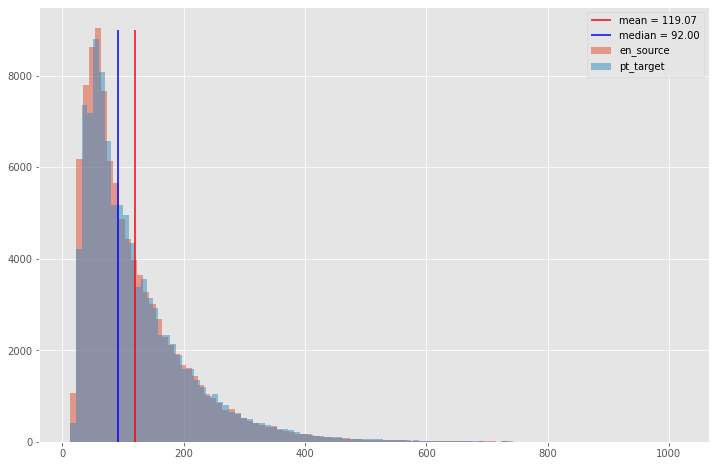

In [13]:
a, b = [len(e[0]) for e in x_train], [len(e[1]) for e in x_train]
c = a + b
counts, bins = np.histogram(a, 100)
counts1, bins1 = np.histogram(b, 100)
plt.hist(bins[:-1], bins, weights=counts, alpha=0.5)
plt.hist(bins1[:-1], bins1, weights=counts1, alpha=0.5)
plt.vlines(np.mean(c), 0, 9000, color='r')
plt.vlines(np.median(c), 0, 9000, color='b')
plt.legend([f'mean = {np.mean(c):.2f}', f'median = {np.median(c):.2f}', 'en_source', 'pt_target'])
plt.plot()
plt.show()

## Dataset class

In [14]:
# Dataset
t5_tokenizer = T5Tokenizer.from_pretrained(model_name)


class MyDataset(Dataset):
    def __init__(self, text_pairs: List[Tuple[str]], tokenizer = t5_tokenizer,
                 source_max_length: int = 128, target_max_length: int = 128):
        self.tokenizer = tokenizer
        self.text_pairs = text_pairs
        self.source_max_length = source_max_length
        self.target_max_length = target_max_length
        
    def __len__(self):
        return len(self.text_pairs)
    
    def __getitem__(self, idx):
        source, target = self.text_pairs[idx]
        

        dict_source = self.tokenizer.encode_plus(
            ' '.join(['translate English to Portuguese:', source, self.tokenizer.eos_token]),
            pad_to_max_length=True,
            max_length=self.source_max_length,
            return_attention_mask = True,
            return_token_type_ids=False,
            return_tensors='pt'
            )
        
        source_token_ids = dict_source['input_ids'][0]
        source_mask = dict_source['attention_mask'][0]

        dict_target = self.tokenizer.encode_plus(
            ' '.join([target, self.tokenizer.eos_token]),
            pad_to_max_length=True,
            max_length=self.target_max_length,
            return_attention_mask = True,
            return_token_type_ids=False,
            return_tensors='pt'
            )
        
        target_token_ids = dict_target['input_ids'][0]
        target_mask = dict_target['attention_mask'][0]

        return (source_token_ids, source_mask, target_token_ids, target_mask,
                source, target)

INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model from cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f


In [15]:
text_pairs = [('we like pizza', 'eu gosto de pizza'),
              ("we don't like pizza", 'eu não gosto de pizza')]
dataset_debug = MyDataset(
    text_pairs=text_pairs,
    tokenizer=t5_tokenizer,
    source_max_length=15,
    target_max_length=15)

dataloader_debug = DataLoader(dataset_debug, batch_size=10, shuffle=True, 
                              num_workers=0)

source_token_ids, source_mask, target_token_ids, target_mask, source, target = next(iter(dataloader_debug))
print('source_token_ids:\n', source_token_ids)
print('source_mask:\n', source_mask)
print('source_tokens:\n', t5_tokenizer.decode(source_token_ids[0]))
print('target_token_ids:\n', target_token_ids)
print('target_mask:\n', target_mask)
print('target_tokens:\n', t5_tokenizer.decode(target_token_ids[0]))

print('source_token_ids.shape:', source_token_ids.shape)
print('source_mask.shape:', source_mask.shape)
print('target_token_ids.shape:', target_token_ids.shape)
print('target_mask.shape:', target_mask.shape)

source_token_ids:
 tensor([[13959,  1566,    12, 21076,    10,    62,   278,    31,    17,   114,
          6871,     1,     0,     0,     0],
        [13959,  1566,    12, 21076,    10,    62,   114,  6871,     1,     0,
             0,     0,     0,     0,     0]])
source_mask:
 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]])
source_tokens:
 translate English to Portuguese: we don't like pizza
target_token_ids:
 tensor([[   3,   15,   76,    3,   29,    2,   32,  281,    7,  235,   20, 6871,
            1,    0,    0],
        [   3,   15,   76,  281,    7,  235,   20, 6871,    1,    0,    0,    0,
            0,    0,    0]])
target_mask:
 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]])
target_tokens:
 eu n ⁇ o gosto de pizza
source_token_ids.shape: torch.Size([2, 15])
source_mask.shape: torch.Size([2, 15])
target_token_ids.shape: torch.Size([2, 15])
target_m

## Model class

In [0]:
class T5Finetuner(pl.LightningModule):

    def __init__(self,
                 tokenizer = t5_tokenizer,
                 learning_rate = 1e-3,
                 batch_size=32,
                 source_max_length=128,
                 target_max_length=128,
                 weight_decay=0.001,
                 generate_strategy='topp',
                 optimizer='ranger',
                 train_pct=1, # percentage used in training
                 val_pct=1,    # percentage used in validation
                 x_train=x_train,
                 x_val=x_val,
                 ):
        super(T5Finetuner, self).__init__()

        self.model = T5ForConditionalGeneration.from_pretrained(model_name)
        
        self.tokenizer = tokenizer
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.target_max_length = target_max_length
        self.source_max_length = source_max_length
        self.weight_decay = weight_decay
        self.optimizer = optimizer,
        self.generate_strategy = generate_strategy

        if optimizer == 'adamw':
            self.optimizer_step = self.warmup_step

        max_train = max(1, math.floor(len(x_train)*train_pct))
        max_val = max(1, math.floor(len(x_val)*val_pct))
        self.x_train_pct = x_train[:max_train]
        self.x_val_pct = x_val[:max_val]

        if use_cuda:
            self.pin_mem = True
            self.n_workers = 0
        else:
            self.pin_mem = False
            self.n_workers = nproc


    def prepare_data(self):
        self.train_data = MyDataset(
                text_pairs=self.x_train_pct,
                tokenizer=self.tokenizer,
                source_max_length=self.source_max_length,
                target_max_length=self.target_max_length)
        
        self.valid_data = MyDataset(
                text_pairs=self.x_val_pct,
                tokenizer=self.tokenizer,
                source_max_length=self.source_max_length,
                target_max_length=self.target_max_length)
        
        self.test_data = MyDataset(
                text_pairs=x_test,
                tokenizer=self.tokenizer,
                source_max_length=self.source_max_length,
                target_max_length=self.target_max_length)
    
    @gpu_mem_restore
    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size,
                          shuffle=True, num_workers=self.n_workers,
                          pin_memory=self.pin_mem)

    @gpu_mem_restore
    def val_dataloader(self):
        return DataLoader(self.valid_data, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.n_workers,
                          pin_memory=self.pin_mem)

    @gpu_mem_restore
    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.n_workers,
                          pin_memory=self.pin_mem)
        
    
    def configure_optimizers(self):
        if self.optimizer == 'ranger':
            optimizer = Ranger(
                [e for e in self.parameters() if e.requires_grad],
                lr=self.learning_rate,
                alpha=0.5,
                k=6,
                betas=(0.9, 0.999),
                eps=1e-08,
                weight_decay=self.weight_decay
            )
        else:
            optimizer = torch.optim.AdamW(
                [e for e in self.parameters() if e.requires_grad],
                lr=self.learning_rate,
                betas=(0.9, 0.999),
                eps=1e-08,
                weight_decay=self.weight_decay
            )
        return optimizer

    def warmup_step(self, current_epoch, batch_nb, optimizer, optimizer_i, second_order_closure=None):
        # Based on: https://pytorch-lightning.readthedocs.io/en/latest/optimizers.html
        # warm up lr
        if self.trainer.global_step < 1000:
            lr_scale = min(1., float(self.trainer.global_step + 1) / 500.)
            for pg in optimizer.param_groups:
                pg['lr'] = lr_scale * self.learning_rate

        # update params
        optimizer.step()
        optimizer.zero_grad()

    def forward(self, source_token_ids, source_mask, target_token_ids=None,
                target_mask=None):
        if self.training:
            outputs = self.model.forward(
                input_ids = source_token_ids,
                attention_mask = source_mask,
                lm_labels  = target_token_ids,
                )
            loss = outputs[0]
            return loss
        else:
            if self.generate_strategy == 'topk':
                predicted_token_ids = self.model.generate(
                    input_ids = source_token_ids,
                    attention_mask = source_mask,
                    top_k = 50, # Limit this, because there's only one reference sentence
                    max_length=self.target_max_length,
                    do_sample=True,
                    )
            elif self.generate_strategy == 'topp':
                predicted_token_ids = self.model.generate(
                    input_ids = source_token_ids,
                    attention_mask = source_mask,
                    top_p = 0.9,
                    max_length=self.target_max_length,
                    do_sample=True,
                    )
            else:
                predicted_token_ids = self.model.generate(
                    input_ids = source_token_ids,
                    attention_mask = source_mask,
                    max_length=self.target_max_length,
                    do_sample = True,
                    num_beams = 3,
                    early_stopping = True,
                    )
            return predicted_token_ids


    def bleu(self, trues, preds):
        bleu = sacrebleu.sentence_bleu(preds, [trues])
        return bleu.score

    def training_step(self, batch, batch_nb):
        input_ids, attn_mask, target_token_ids, _,  _, _ = batch
        loss = self(input_ids, attn_mask, target_token_ids)

        logs = {'train_loss': loss,}

        return {
            'loss': loss,
            'log': logs,
            }

    
    def validation_step(self, batch, batch_nb):
        input_ids, attn_mask, _, _, _, target = batch
        pred = self(input_ids, attn_mask)
        translation = [self.tokenizer.decode(e) for e in pred]
        bleu_score = self.bleu(target, translation)

        logs = {'val_bleu': bleu_score,}

        return {
            'progress_bar': logs,
            'val_bleu': bleu_score,
            'log': logs,
            }


    def test_step(self, batch, batch_nb):
        input_ids, attn_mask, _, _, _, target = batch
        pred = self(input_ids, attn_mask)
        translation = [self.tokenizer.decode(e) for e in pred]
        bleu_score = self.bleu(target, translation)

        logs = {'test_bleu': bleu_score,}

        return {
            'progress_bar': logs,
            'test_bleu': bleu_score,
            'log': logs,
            }

    def validation_epoch_end(self, outputs):
        avg_bleu = sum([x['val_bleu'] for x in outputs]) / len(outputs)
        logs = {'avg_val_bleu': avg_bleu}       
        return {'avg_val_bleu': avg_bleu, 'progress_bar': logs, 'log': logs}

    def test_epoch_end(self, outputs):
        avg_bleu = sum([x['test_bleu'] for x in outputs]) / len(outputs)
        logs = {'avg_test_bleu': avg_bleu}       
        return {'avg_test_bleu': avg_bleu, 'progress_bar': logs}

In [17]:
model = T5Finetuner()

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/t5-small-config.json from cache at /root/.cache/torch/transformers/26561bc9e840d8945f475d0d4c4b9df32025eadd79894b867b570cb1d09e67a9.3817cc1260a6b941b17af62b4f2a942b9825f209d8e2eed99e79e96f85f59aab
INFO:transformers.configuration_utils:Model config T5Config {
  "_num_labels": 2,
  "architectures": [
    "T5WithLMHeadModel"
  ],
  "bad_words_ids": null,
  "bos_token_id": null,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "do_sample": false,
  "dropout_rate": 0.1,
  "early_stopping": false,
  "eos_token_id": 1,
  "finetuning_task": null,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_factor": 1.0,
  "is_decoder": false,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_epsilon": 1e-06,
  "length_penalty": 1.0,
  "max_length": 20,
  "min_length": 0,
  "model_type

In [18]:
sum([torch.tensor(x.size()).prod() for x in model.parameters() if x.requires_grad]) # trainable parameters

tensor(60506880)

In [19]:
# Simple tests
print('source:', source)
print('target:', target)
model.train()
loss = model(source_token_ids, source_mask, target_token_ids)
loss.backward()
print('train:', loss)
model.eval()
pred = model(source_token_ids, source_mask)
print('eval:', pred)
translation = [t5_tokenizer.decode(e) for e in pred]
print('translation:',translation)
score = model.bleu(target, translation)
print('bleu',score)
del model

source: ("we don't like pizza", 'we like pizza')
target: ('eu não gosto de pizza', 'eu gosto de pizza')
train: tensor(6.3653, grad_fn=<NllLossBackward>)
eval: tensor([[    0,  3625, 25297,    15,     7,  2499,   311,  2288,  7049, 15365,
             1,     0,     0,     0,     0,     0,     0],
        [    0,     3,  9446,  2745,  5271,  4476,     3,  8980,    17,   211,
          3625, 25297,    15,     7,  2014,     5,     1]])
translation: ['Portugiesisch nicht mochten Pizza', 'Unsere Pizzeria liebt das Portugiesische.']
bleu 0.0


In [20]:
model = T5Finetuner(
    batch_size=32,
    source_max_length = 120,
    target_max_length = 150,
)

trainer = pl.Trainer(gpus=1,
                     weights_summary=None,
                     fast_dev_run = True,
                     )

trainer.fit(model)
trainer.test(model)
del model

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/t5-small-config.json from cache at /root/.cache/torch/transformers/26561bc9e840d8945f475d0d4c4b9df32025eadd79894b867b570cb1d09e67a9.3817cc1260a6b941b17af62b4f2a942b9825f209d8e2eed99e79e96f85f59aab
INFO:transformers.configuration_utils:Model config T5Config {
  "_num_labels": 2,
  "architectures": [
    "T5WithLMHeadModel"
  ],
  "bad_words_ids": null,
  "bos_token_id": null,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "do_sample": false,
  "dropout_rate": 0.1,
  "early_stopping": false,
  "eos_token_id": 1,
  "finetuning_task": null,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_factor": 1.0,
  "is_decoder": false,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_epsilon": 1e-06,
  "length_penalty": 1.0,
  "max_length": 20,
  "min_length": 0,
  "model_type

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: Can save best model only with val_loss available, skipping.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


--------------------------------------------------------------------------------
TEST RESULTS
{'avg_test_bleu': 1.7377584850577146}
--------------------------------------------------------------------------------



## Experiments


In [21]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

<IPython.core.display.Javascript object>

### Ranger / 64 / 90-120 / topp

In [0]:
BASE_DIR = '/content/drive/My Drive/aula9_checkpoints/'
EPOCHS = 5
BS = 64
LR = 3e-3
ACC = 8
OPTIMIZER = 'ranger'
STRATEGY = 'topp'
MAX_LEN_SOURCE = 90
MAX_LEN_TARGET = 120
WDECAY=0
EXP_NAME= 'ranger_64_90_120_topp'

In [23]:
# From Lucas Ueda
cptk_path = os.path.join(BASE_DIR, EXP_NAME, "{epoch}--{avg_val_bleu:.2f}")

# Define o checkpoint
checkpoint_callback = ModelCheckpoint(filepath=cptk_path,               
                                      save_top_k=-1)  # Keeps all checkpoints.

path = os.path.join(BASE_DIR, EXP_NAME, 'epoch=2--avg_val_bleu=26.19.ckpt')
resume_from_checkpoint = None
continue_ = True

model = T5Finetuner()

if(os.path.exists(path)&(continue_ == True)):
    print(f'Restoring checkpoint: {path}')
    resume_from_checkpoint = path

trainer = pl.Trainer(gpus=1,
                     weights_summary=None,
                     max_epochs=EPOCHS,
                     check_val_every_n_epoch=1,
                     val_check_interval=0.5,
                     profiler=True,
                     accumulate_grad_batches=ACC,
                     checkpoint_callback=checkpoint_callback,
                     resume_from_checkpoint=resume_from_checkpoint,
                     num_sanity_val_steps=0)

trainer.fit(model)

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/t5-small-config.json from cache at /root/.cache/torch/transformers/26561bc9e840d8945f475d0d4c4b9df32025eadd79894b867b570cb1d09e67a9.3817cc1260a6b941b17af62b4f2a942b9825f209d8e2eed99e79e96f85f59aab
INFO:transformers.configuration_utils:Model config T5Config {
  "_num_labels": 2,
  "architectures": [
    "T5WithLMHeadModel"
  ],
  "bad_words_ids": null,
  "bos_token_id": null,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "do_sample": false,
  "dropout_rate": 0.1,
  "early_stopping": false,
  "eos_token_id": 1,
  "finetuning_task": null,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_factor": 1.0,
  "is_decoder": false,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_epsilon": 1e-06,
  "length_penalty": 1.0,
  "max_length": 20,
  "min_length": 0,
  "model_type

Restoring checkpoint: /content/drive/My Drive/aula9_checkpoints/ranger_64_90_120_topp/epoch=2--avg_val_bleu=26.19.ckpt


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


INFO:lightning:

Profiler Report

Action              	|  Mean duration (s)	|  Total time (s) 
-----------------------------------------------------------------
on_train_start      	|  0.019205       	|  0.019205       
on_epoch_start      	|  0.0023112      	|  0.0046223      
get_train_batch     	|  0.021359       	|  133.53         
on_batch_start      	|  1.3285e-05     	|  0.083031       
model_forward       	|  0.048676       	|  304.22         
model_backward      	|  0.25024        	|  1564.0         
on_after_backward   	|  4.0057e-06     	|  0.025036       
on_batch_end        	|  0.0017414      	|  10.884         
optimizer_step      	|  0.015283       	|  11.921         
on_epoch_end        	|  1.0179e-05     	|  2.0359e-05     
on_train_end        	|  0.0011239      	|  0.0011239      



1

In [24]:
trainer.test(model)

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: You're resuming from a checkpoint that ended mid-epoch. This can cause unreliable results if further training is done, consider using an end of epoch checkpoint. 
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


--------------------------------------------------------------------------------
TEST RESULTS
{'avg_test_bleu': 26.227002432434517}
--------------------------------------------------------------------------------



In [0]:
del model, trainer

### AdamW / 64 / 90 / 120 / topp

In [0]:
BASE_DIR = '/content/drive/My Drive/aula9_checkpoints/'
EPOCHS = 5
BS = 64
LR = 1e-3
ACC = 8
OPTIMIZER = 'adamw'
STRATEGY = 'topp'
MAX_LEN_SOURCE = 90
MAX_LEN_TARGET = 120
WDECAY=1e-3
EXP_NAME= 'adamw_64_90_120_topp'

In [27]:
cptk_path = os.path.join(BASE_DIR, EXP_NAME, "{epoch}--{avg_val_bleu:.2f}")

# Define o checkpoint
checkpoint_callback = ModelCheckpoint(filepath=cptk_path,
                                      save_top_k=-1)  # Keeps all checkpoints.

path = os.path.join(BASE_DIR, EXP_NAME, '--epoch=1--avg_val_bleu=23.87.ckpt')
resume_from_checkpoint = None
continue_ = True

model = T5Finetuner()

if(os.path.exists(path)&(continue_ == True)):
    print(f'Restoring checkpoint: {path}')
    resume_from_checkpoint = path

trainer = pl.Trainer(gpus=1,
                     weights_summary=None,
                     max_epochs=EPOCHS,
                     check_val_every_n_epoch=1,
                     profiler=True,
                     accumulate_grad_batches=ACC,
                     checkpoint_callback=checkpoint_callback,
                     resume_from_checkpoint=resume_from_checkpoint,
                     num_sanity_val_steps=0)


trainer.fit(model)

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/t5-small-config.json from cache at /root/.cache/torch/transformers/26561bc9e840d8945f475d0d4c4b9df32025eadd79894b867b570cb1d09e67a9.3817cc1260a6b941b17af62b4f2a942b9825f209d8e2eed99e79e96f85f59aab
INFO:transformers.configuration_utils:Model config T5Config {
  "_num_labels": 2,
  "architectures": [
    "T5WithLMHeadModel"
  ],
  "bad_words_ids": null,
  "bos_token_id": null,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "do_sample": false,
  "dropout_rate": 0.1,
  "early_stopping": false,
  "eos_token_id": 1,
  "finetuning_task": null,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_factor": 1.0,
  "is_decoder": false,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_epsilon": 1e-06,
  "length_penalty": 1.0,
  "max_length": 20,
  "min_length": 0,
  "model_type

Restoring checkpoint: /content/drive/My Drive/aula9_checkpoints/adamw_64_90_120_topp/--epoch=1--avg_val_bleu=23.87.ckpt


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


INFO:lightning:

Profiler Report

Action              	|  Mean duration (s)	|  Total time (s) 
-----------------------------------------------------------------
on_train_start      	|  0.021215       	|  0.021215       
on_epoch_start      	|  0.0025047      	|  0.0075142      
get_train_batch     	|  0.020954       	|  196.51         
on_batch_start      	|  1.3199e-05     	|  0.12374        
model_forward       	|  0.048212       	|  451.99         
model_backward      	|  0.24982        	|  2342.1         
on_after_backward   	|  3.7693e-06     	|  0.035338       
on_batch_end        	|  0.0017194      	|  16.12          
optimizer_step      	|  0.015037       	|  17.593         
on_epoch_end        	|  2.2003e-05     	|  6.6009e-05     
on_train_end        	|  0.0016553      	|  0.0016553      



1

In [28]:
trainer.test(model)

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


--------------------------------------------------------------------------------
TEST RESULTS
{'avg_test_bleu': 24.15897134700815}
--------------------------------------------------------------------------------



In [0]:
del trainer, model